In [79]:
# Standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# Geospatial data processing
import laspy
import geopandas as gpd

# 3D and scientific computing
import open3d as o3d
from scipy.spatial import KDTree, cKDTree
from scipy.interpolate import griddata
from scipy.ndimage import distance_transform_edt
from shapely.geometry import Polygon, Point, box, LineString
import statsmodels.api as sm


# Image processing
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.color import label2rgb
from scipy.stats import binned_statistic_2d
from skimage.feature import peak_local_max
from scipy.spatial.transform import Rotation as R
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import NearestNeighbors


# Display settings
%matplotlib inline

In [80]:
class LASProcessor:
    def __init__(self, filepath):
        self.filepath = filepath
        self.raw_data = None
        self.points = None
        self.classifications = None
        self.ground_points = None
        self.non_ground_points = None
        self.normalized_points = None
        self.ground_elevations = None

    def load_data(self):
        try:
            self.raw_data = laspy.read(self.filepath)
            self.points = np.vstack((self.raw_data.x, self.raw_data.y, self.raw_data.z)).transpose()
            self.classifications = self.raw_data.classification
        except Exception as e:
            print(f"Failed to load data: {e}")

    def separate_points(self):
        self.ground_points = self.points[self.classifications == 2]
        self.non_ground_points = self.points[self.classifications != 2]

    def normalize_elevation(self):
        ground_df = pd.DataFrame(self.ground_points, columns=['x', 'y', 'z'])
        ground_df_mean = ground_df.groupby(['x', 'y']).mean().reset_index()
        F = griddata(ground_df_mean[['x', 'y']], ground_df_mean['z'], (self.points[:, 0], self.points[:, 1]), method='nearest')
        self.ground_elevations = F.flatten()
        self.normalized_points = np.copy(self.points)
        self.normalized_points[:, 2] -= self.ground_elevations

    def create_point_cloud(self, points, color=None):
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        
        if color is None:
            # Normalize height values to the 0-1 range for coloring
            z_values = points[:, 2] - points[:, 2].min()
            z_values /= z_values.max()
            cmap = plt.get_cmap('viridis')  # You can choose any colormap you like
            colors = cmap(z_values)[:, :3]  # Ignore alpha channel
            pcd.colors = o3d.utility.Vector3dVector(colors)
        else:
            pcd.paint_uniform_color(color)
        
        return pcd
    
    def display_color_map(self):
        fig, ax = plt.subplots(figsize=(6, 1))
        fig.subplots_adjust(bottom=0.5)

        cmap = plt.get_cmap('viridis')
        norm = plt.Normalize(vmin=self.normalized_points[:, 2].min(), vmax=self.normalized_points[:, 2].max())
        cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
        cb.set_label('Elevation (normalized)')
        plt.show()

    def visualize(self, point_clouds):
        o3d.visualization.draw_geometries(point_clouds)

    def process(self):
        self.load_data()
        self.separate_points()
        self.normalize_elevation()
        
        ground_pcd = self.create_point_cloud(self.ground_points, [0, 0, 1])
        non_ground_pcd = self.create_point_cloud(self.non_ground_points, [1, 0, 0])
        
        # Visualize initial point clouds with ground and non-ground classification
        self.visualize([ground_pcd, non_ground_pcd])
        
        normalized_pcd = self.create_point_cloud(self.normalized_points)
        self.visualize([normalized_pcd])

        # Optionally, display the color map
        self.display_color_map()

In [81]:
class CanopyHeightModel:
    def __init__(self, las_processor, grid_size=200, min_distance=3):
        self.las_processor = las_processor
        self.grid_size = grid_size
        self.min_distance = min_distance
        self.bin_statistic = None
        self.coordinates = None
        self.x_edge = None
        self.y_edge = None

    def calculate_canopy_height(self):
        non_ground_normalized_points = self.las_processor.normalized_points[self.las_processor.classifications != 2]
        bin_statistic, x_edge, y_edge, binnumber = binned_statistic_2d(
            non_ground_normalized_points[:, 0],
            non_ground_normalized_points[:, 1],
            non_ground_normalized_points[:, 2],
            statistic='max',
            bins=[self.grid_size, self.grid_size]
        )
        self.bin_statistic = np.nan_to_num(bin_statistic)
        self.x_edge = x_edge
        self.y_edge = y_edge

    def detect_tree_tops(self):
        self.coordinates = peak_local_max(self.bin_statistic, min_distance=self.min_distance, labels=None)

    def get_tree_top_coordinates(self):
        x_bin_centers = (self.x_edge[:-1] + self.x_edge[1:]) / 2
        y_bin_centers = (self.y_edge[:-1] + self.y_edge[1:]) / 2
        x_coords = x_bin_centers[self.coordinates[:, 1]]
        y_coords = y_bin_centers[self.coordinates[:, 0]]
        return np.column_stack((x_coords, y_coords))

    def plot_canopy_height(self):
        plt.imshow(self.bin_statistic, origin='lower', cmap='viridis')
        plt.colorbar(label='Height (m)')
        plt.title('Canopy Height Model')
        plt.show()

    def plot_tree_tops(self):
        plt.imshow(self.bin_statistic, cmap='viridis', origin='lower')
        plt.plot(self.coordinates[:, 1], self.coordinates[:, 0], 'r.')
        plt.colorbar(label='Height (m)')
        plt.title('Canopy Height Model with Tree Tops')
        plt.show()

    def process(self):
        self.calculate_canopy_height()
        self.plot_canopy_height()
        self.detect_tree_tops()
        print(f"Number of detected tree tops: {len(self.coordinates)}")
        self.plot_tree_tops()
        actual_coords = self.get_tree_top_coordinates()

In [82]:
class TreeHeightCalculator:
    def __init__(self, las_processor, base_search_radius=1.0):
        self.las_processor = las_processor
        self.base_search_radius = base_search_radius
        if las_processor.normalized_points is not None:
            self.kd_tree = KDTree(las_processor.normalized_points[:, :2])
        else:
            raise ValueError("Normalized points not available. Ensure LASProcessor has run normalize_elevation().")

    def calculate_tree_heights(self, tree_coordinates):
        tree_heights = []
        for coord in tree_coordinates:
            local_density = len(self.kd_tree.query_ball_point(coord, self.base_search_radius))
            if local_density == 0:
                tree_heights.append(np.nan)
                continue
            adjusted_radius = self.base_search_radius * (1 + (10 / local_density))
            indices = self.kd_tree.query_ball_point(coord, adjusted_radius)
            if not indices:
                tree_heights.append(np.nan)
                continue
            heights = self.las_processor.normalized_points[indices, 2]
            combined_height = (np.max(heights) + np.median(heights) + np.mean(heights)) / 3
            tree_heights.append(combined_height)
        return tree_heights

In [83]:
class CrownRadiusCalculator:
    def __init__(self, points, pixel_size):
        self.points = points
        self.pixel_size = pixel_size
        self.tree = cKDTree(points[:, :2])

    def calculate_crown_radius(self, tree_top_coords, search_radius=5):
        indices = self.tree.query_ball_point(tree_top_coords, search_radius)
        canopy_area = len(indices) * self.pixel_size
        crown_radius = np.sqrt(canopy_area / np.pi)
        return crown_radius


In [84]:
class HeightEstimationMetrics:
    def __init__(self, reference_path, detected_gdf):
        self.reference_gdf = gpd.read_file(reference_path)
        self.detected_gdf = detected_gdf
        self.reference_points = np.array([(geom.x, geom.y) for geom in self.reference_gdf.geometry])
        self.reference_heights = self.reference_gdf['HRef'].to_numpy()
        self.detected_coords = np.array([(geom.x, geom.y) for geom in detected_gdf.geometry])
        self.detected_heights = detected_gdf['HRef'].to_numpy()

    def normalize_points(self):
        ref_min_x, ref_max_x = self.reference_points[:, 0].min(), self.reference_points[:, 0].max()
        ref_min_y, ref_max_y = self.reference_points[:, 1].min(), self.reference_points[:, 1].max()

        det_min_x, det_max_x = self.detected_coords[:, 0].min(), self.detected_coords[:, 0].max()
        det_min_y, det_max_y = self.detected_coords[:, 1].min(), self.detected_coords[:, 1].max()

        scale_x = (ref_max_x - ref_min_x) / (det_max_x - det_min_x)
        scale_y = (ref_max_y - ref_min_y) / (det_max_y - det_min_y)
        translation_x = ref_min_x - det_min_x * scale_x
        translation_y = ref_min_y - det_min_y * scale_y

        self.normalized_detected_coords = self.detected_coords * [scale_x, scale_y]
        self.translated_detected_coords = self.normalized_detected_coords + [translation_x, translation_y]
        self.detected_gdf['geometry'] = [Point(coord) for coord in self.translated_detected_coords]

    def sort_and_adjust(self):
        sorted_ref_indices = np.argsort(self.reference_heights)
        sorted_det_indices = np.argsort(self.detected_heights)

        self.sorted_reference_points = self.reference_points[sorted_ref_indices]
        self.sorted_reference_heights = self.reference_heights[sorted_ref_indices]

        self.sorted_detected_coords = self.translated_detected_coords[sorted_det_indices]
        self.sorted_detected_heights = self.detected_heights[sorted_det_indices]

        self.adjusted_coords = self.sorted_reference_points
        self.adjusted_heights = self.sorted_reference_heights

        adjusted_detected_data = {
            'DBHRef': np.zeros(len(self.adjusted_coords)),
            'HRef': self.sorted_detected_heights,
            'VolRef': np.zeros(len(self.adjusted_coords)),
            'geometry': [Point(coord) for coord in self.adjusted_coords]
        }

        self.adjusted_detected_gdf = gpd.GeoDataFrame(adjusted_detected_data, geometry='geometry')

    def calculate_metrics(self):
        self.mae = np.mean(np.abs(self.adjusted_heights - self.sorted_detected_heights))
        self.rmse = np.sqrt(mean_squared_error(self.adjusted_heights, self.sorted_detected_heights))
        self.mape = np.mean(np.abs((self.adjusted_heights - self.sorted_detected_heights) / self.adjusted_heights)) * 100
        self.r2 = r2_score(self.adjusted_heights, self.sorted_detected_heights)
        self.bias = np.mean(self.sorted_detected_heights - self.adjusted_heights)
        self.si = self.rmse / np.mean(self.adjusted_heights)
        self.pearson_corr = np.corrcoef(self.adjusted_heights, self.sorted_detected_heights)[0, 1]
        self.errors = self.sorted_detected_heights - self.adjusted_heights

    def filter_outliers(self):
        Q1 = np.percentile(self.errors, 25)
        Q3 = np.percentile(self.errors, 75)
        IQR = Q3 - Q1
        outlier_threshold = 1.5 * IQR

        filtered_indices = np.where((self.errors >= Q1 - outlier_threshold) & (self.errors <= Q3 + outlier_threshold))[0]
        self.filtered_matched_points = pd.DataFrame({
            'HRef_ref': self.adjusted_heights[filtered_indices],
            'HRef_detected': self.sorted_detected_heights[filtered_indices]
        })
        self.filtered_errors = self.errors[filtered_indices]

    def regression_analysis(self):
        X_filtered = sm.add_constant(self.filtered_matched_points['HRef_ref'])
        self.model_filtered = sm.OLS(self.filtered_matched_points['HRef_detected'], X_filtered).fit()
        print(self.model_filtered.summary())

        plt.figure(figsize=(10, 6))
        plt.scatter(self.filtered_matched_points['HRef_ref'], self.filtered_matched_points['HRef_detected'], alpha=0.5)
        plt.plot(self.filtered_matched_points['HRef_ref'], self.model_filtered.predict(X_filtered), 'r--', label='Regression Line')
        plt.xlabel('Reference Heights (m)')
        plt.ylabel('Detected Heights (m)')
        plt.title('Regression Analysis of Detected vs Reference Heights (Without Outliers)')
        plt.legend()
        plt.show()

    def plot_error_distribution(self):
        plt.figure(figsize=(10, 6))
        plt.hist(self.filtered_errors, bins=20, color='blue', edgecolor='black')
        plt.title('Distribution of Errors in Tree Height Estimation (Without Outliers)')
        plt.xlabel('Error (m)')
        plt.ylabel('Frequency')
        plt.show()

        height_ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30)]
        range_labels = ['0-5m', '5-10m', '10-15m', '15-20m', '20-25m', '25-30m']
        filtered_errors_in_ranges = {label: [] for label in range_labels}

        for ref_height, error in zip(self.filtered_matched_points['HRef_ref'], self.filtered_errors):
            for i, (low, high) in enumerate(height_ranges):
                if low <= ref_height < high:
                    filtered_errors_in_ranges[range_labels[i]].append(error)

        plt.figure(figsize=(12, 8))
        plt.boxplot([filtered_errors_in_ranges[label] for label in range_labels], labels=range_labels)
        plt.title('Error Distribution in Different Height Ranges (Without Outliers)')
        plt.xlabel('Height Range (m)')
        plt.ylabel('Error (m)')
        plt.show()

    def plot_movement_lines(self):
        lines = [LineString([self.sorted_detected_coords[i], self.adjusted_coords[i]]) for i in range(len(self.adjusted_coords))]
        lines_gdf = gpd.GeoDataFrame(geometry=lines)

        fig, ax = plt.subplots(figsize=(12, 10))
        self.reference_gdf.plot(ax=ax, color='blue', marker='o', label='Reference Points')
        bounding_box_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
        grid_gdf.boundary.plot(ax=ax, color='grey', linewidth=0.5, linestyle='--', label='Grid')
        self.detected_gdf.plot(ax=ax, color='green', marker='x', label='Original Detected Points')
        self.adjusted_detected_gdf.plot(ax=ax, color='purple', marker='x', label='Adjusted Detected Points')
        lines_gdf.plot(ax=ax, color='black', linewidth=0.1, linestyle='-', label='Movement Lines')

        plt.title("Movement of Detected Points to Match Reference Points")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()

    def plot_cdf_errors(self):
        sorted_errors = np.sort(self.filtered_errors)
        cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

        plt.figure(figsize=(10, 6))
        plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
        plt.xlabel('Error (m)')
        plt.ylabel('Cumulative Probability')
        plt.title('Cumulative Distribution Function (CDF) of Errors')
        plt.grid(True)
        plt.show()

    def run_pipeline(self):
        self.normalize_points()
        self.sort_and_adjust()
        self.calculate_metrics()
        self.filter_outliers()
        self.regression_analysis()
        self.plot_error_distribution()
        self.plot_movement_lines()
        self.plot_cdf_errors()

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


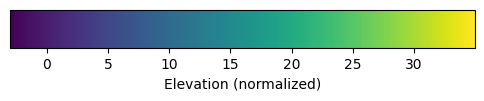

In [85]:
processor = LASProcessor("./test_data/LIDAR.las")
processor.process()

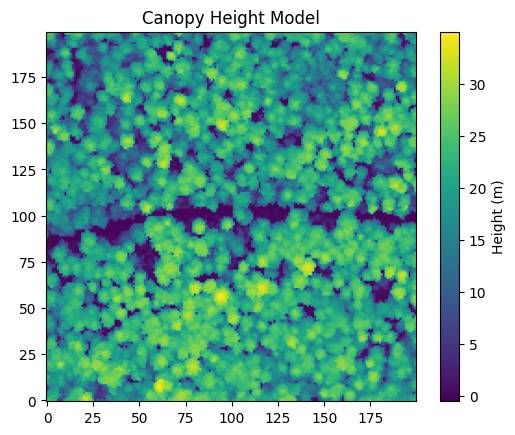

Number of detected tree tops: 359


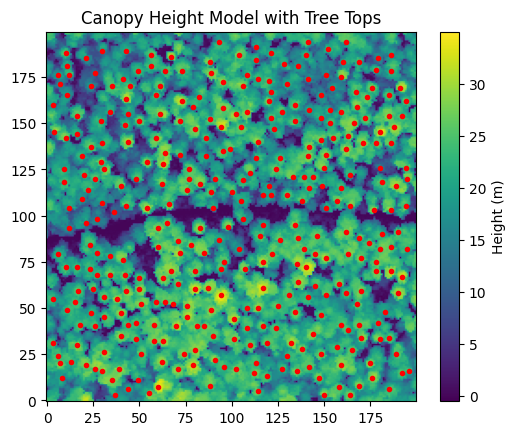

In [86]:
chm = CanopyHeightModel(processor)
chm.process()

In [87]:
def compute_accuracy(detected_tree_tops, reference_points, threshold_distance=5.0):
    ref_tree = KDTree(reference_points)
    distances, _ = ref_tree.query(detected_tree_tops)
    accuracy = np.sum(distances <= threshold_distance) / len(detected_tree_tops)
    return accuracy

In [88]:
data = gpd.read_file('./test_data/Reference.shp')
reference_heights = data['HRef'].to_numpy()
reference_points = data.geometry.apply(lambda geom: (geom.x, geom.y)).to_list()
detected_tree_tops = chm.get_tree_top_coordinates()
accuracy = compute_accuracy(detected_tree_tops, reference_points)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.25


In [89]:
tree_height_calculator = TreeHeightCalculator(processor, base_search_radius=2.9)
tree_heights = tree_height_calculator.calculate_tree_heights(detected_tree_tops)
tree_heights_array = np.array(tree_heights)

In [90]:
reference_points = np.array(data.geometry.apply(lambda geom: (geom.x, geom.y)).to_list())


In [91]:
def match_tree_tops(detected_coords, reference_coords, detected_heights, reference_heights, threshold=2.0):
    matched_heights = []
    matched_references = []
    used_indices = set()
    
    for i, det_coord in enumerate(detected_coords):
        min_dist = float('inf')
        min_index = -1
        for j, ref_coord in enumerate(reference_coords):
            if j in used_indices:
                continue
            dist = np.linalg.norm(np.array(det_coord) - np.array(ref_coord))
            if dist < min_dist and dist <= threshold:
                min_dist = dist
                min_index = j
        if min_index != -1:
            matched_heights.append(detected_heights[i])
            matched_references.append(reference_heights[min_index])
            used_indices.add(min_index)
    
    return np.array(matched_heights), np.array(matched_references)

matched_heights, matched_references = match_tree_tops(detected_tree_tops, reference_points, tree_heights_array, reference_heights)
# Function to calculate MAE
def calculate_mae(predicted, actual):
    return np.mean(np.abs(predicted - actual))
    
# Calculate MAE using the matched heights
mae = calculate_mae(matched_heights, matched_references)
print(f"Mean Absolute Error (MAE): {mae:.2f} meters")


Mean Absolute Error (MAE): 4.25 meters


In [92]:
# Calculate average of reference heights
average_reference_height = np.mean(reference_heights)
print(f"Average Reference Height: {average_reference_height:.2f} meters")

Average Reference Height: 17.15 meters


Average Tree Height: 17.69 meters


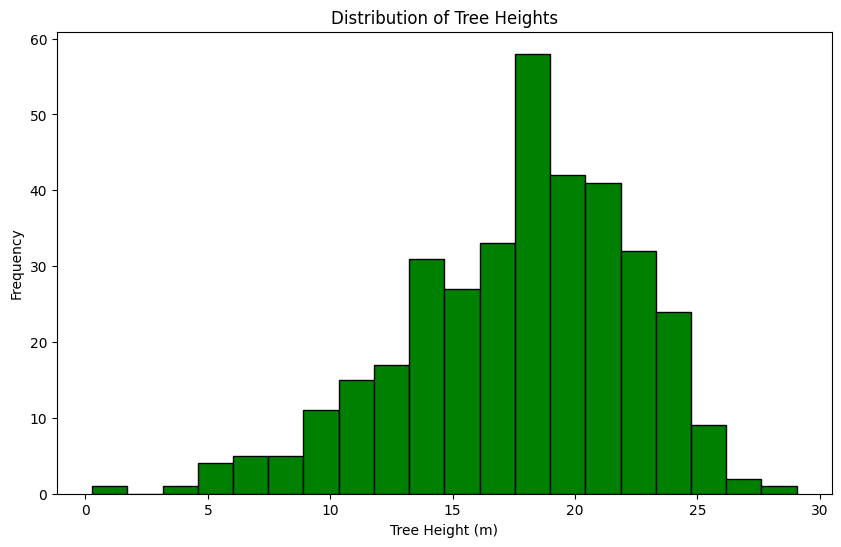

In [93]:
# Average Tree Height
average_tree_height = np.nanmean(tree_heights_array)
print(f"Average Tree Height: {average_tree_height:.2f} meters")

# Distribution of Tree Heights
plt.figure(figsize=(10, 6))
plt.hist(tree_heights_array[~np.isnan(tree_heights_array)], bins=20, color='green', edgecolor='black')
plt.title('Distribution of Tree Heights')
plt.xlabel('Tree Height (m)')
plt.ylabel('Frequency')
plt.show()

In [94]:
# Crown Radius Calculations
diameter_meters = 32 / 100  # converting cm to meters
radius_meters = diameter_meters / 2
area_square_meters = 3.14159 * (radius_meters ** 2)

crown_radius_calculator = CrownRadiusCalculator(processor.points, pixel_size=area_square_meters)
crown_radii = [crown_radius_calculator.calculate_crown_radius(coord) for coord in detected_tree_tops]
crown_radii_array = np.array(crown_radii)

In [95]:
# Average and Standard Deviation of Crown Radii
average_crown_radius = np.nanmean(crown_radii_array)
std_crown_radius = np.nanstd(crown_radii_array)
print(f"Average Crown Radius: {average_crown_radius:.2f} meters")
print(f"Standard Deviation of Crown Radius: {std_crown_radius:.2f} meters")

Average Crown Radius: 4.95 meters
Standard Deviation of Crown Radius: 0.71 meters


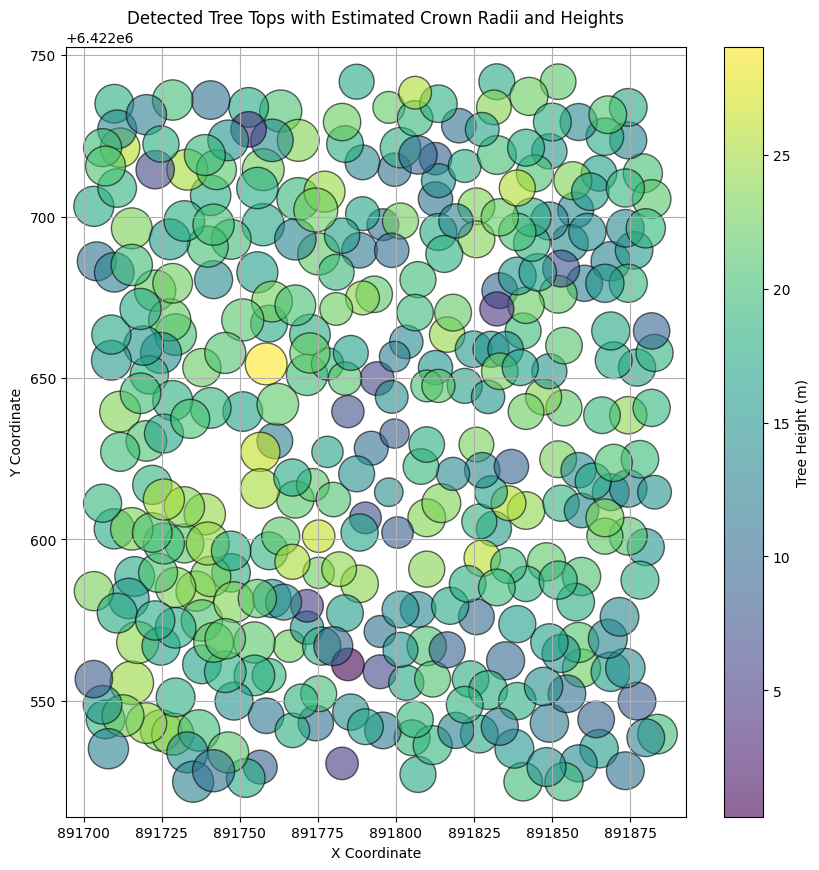

In [96]:
# Plot Detected Tree Tops with Heights and Crown Radii
detected_tree_tops_array = np.array(detected_tree_tops)
tree_heights_array = np.array(tree_heights)
crown_radii_array = np.array(crown_radii)

# Normalize crown radii for plotting (scaled for visibility)
crown_radii_scaled = 1000 * (crown_radii_array / np.max(crown_radii_array))

# Plot Detected Tree Tops with Heights and Crown Radii
plt.figure(figsize=(10, 10))
scatter = plt.scatter(detected_tree_tops_array[:, 0], detected_tree_tops_array[:, 1], 
                      s=crown_radii_scaled, 
                      c=tree_heights_array, 
                      cmap='viridis', alpha=0.6, edgecolor='black')
plt.colorbar(scatter, label='Tree Height (m)')
plt.title('Detected Tree Tops with Estimated Crown Radii and Heights')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [97]:
crown_radius_calculator = CrownRadiusCalculator(processor.points, pixel_size=area_square_meters)
for coord in detected_tree_tops:
    crown_radius = crown_radius_calculator.calculate_crown_radius(coord)
    print(f"Tree at {coord} has an estimated crown radius of {crown_radius:.2f} meters.")

Tree at [ 891756.564475 6422529.512125] has an estimated crown radius of 4.01 meters.
Tree at [ 891788.352775 6422586.259625] has an estimated crown radius of 4.93 meters.
Tree at [ 891809.856625 6422590.799425] has an estimated crown radius of 4.55 meters.
Tree at [ 891868.758475 6422686.135225] has an estimated crown radius of 5.44 meters.
Tree at [ 891831.360475 6422603.283875] has an estimated crown radius of 4.31 meters.
Tree at [ 891788.352775 6422689.540075] has an estimated crown radius of 4.41 meters.
Tree at [ 891740.670325 6422706.564325] has an estimated crown radius of 5.72 meters.
Tree at [ 891775.263475 6422589.664475] has an estimated crown radius of 3.44 meters.
Tree at [ 891879.977875 6422597.609125] has an estimated crown radius of 4.81 meters.
Tree at [ 891750.954775 6422639.602275] has an estimated crown radius of 5.50 meters.
Tree at [ 891768.718825 6422705.429375] has an estimated crown radius of 6.42 meters.
Tree at [ 891759.369325 6422666.841075] has an estimat

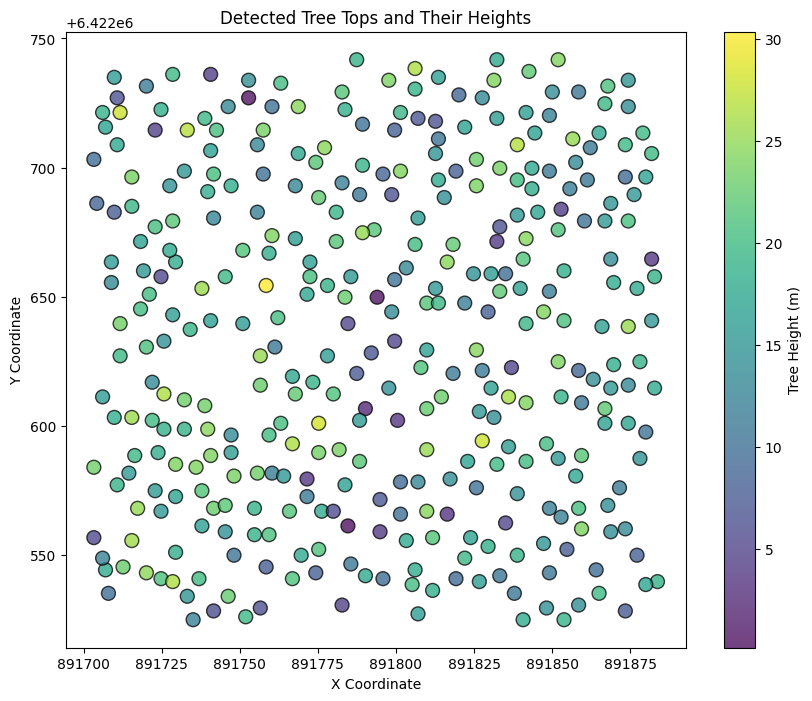

In [98]:
tree_height_calculator = TreeHeightCalculator(processor)

tree_heights = tree_height_calculator.calculate_tree_heights(detected_tree_tops)

tree_heights_array = np.array(tree_heights)
detected_tree_tops_array = np.array(detected_tree_tops)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(detected_tree_tops_array[:, 0], detected_tree_tops_array[:, 1], c=tree_heights_array, cmap='viridis', marker='o', edgecolor='k', s=100, alpha=0.75)

plt.colorbar(scatter, label='Tree Height (m)')

plt.title('Detected Tree Tops and Their Heights')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Display the plot
plt.show()

In [99]:
# Load reference data
reference_heights = data['HRef'].to_numpy()
reference_points = np.array([(geom.x, geom.y) for geom in data.geometry])

# Assuming detected_tree_tops and tree_heights are already calculated
detected_tree_tops = chm.get_tree_top_coordinates()
tree_heights = tree_height_calculator.calculate_tree_heights(detected_tree_tops)

# Determine the bounding box for reference points
ref_min_x, ref_max_x = reference_points[:, 0].min(), reference_points[:, 0].max()
ref_min_y, ref_max_y = reference_points[:, 1].min(), reference_points[:, 1].max()

# Determine the bounding box for detected tree tops
det_min_x, det_max_x = detected_tree_tops[:, 0].min(), detected_tree_tops[:, 0].max()
det_min_y, det_max_y = detected_tree_tops[:, 1].min(), detected_tree_tops[:, 1].max()

# Calculate scale and translation factors
scale_x = (ref_max_x - ref_min_x) / (det_max_x - det_min_x)
scale_y = (ref_max_y - ref_min_y) / (det_max_y - det_min_y)
translation_x = ref_min_x - det_min_x * scale_x
translation_y = ref_min_y - det_min_y * scale_y

# Apply the scaling and translation to detected tree tops
scaled_detected_tree_tops = detected_tree_tops * [scale_x, scale_y]
translated_detected_tree_tops = scaled_detected_tree_tops + [translation_x, translation_y]

# Normalize reference points using the same scaling and translation
normalized_reference_points = reference_points * [scale_x, scale_y] + [translation_x, translation_y]

# Create DataFrame for detected points
detected_data = {
    'DBHRef': np.zeros(len(translated_detected_tree_tops)),
    'HRef': tree_heights,
    'VolRef': np.zeros(len(translated_detected_tree_tops)),
    'geometry': [Point(coord) for coord in translated_detected_tree_tops]
}

detected_gdf = gpd.GeoDataFrame(detected_data, geometry='geometry')

# Create DataFrame for normalized reference points
reference_data = {
    'DBHRef': data['DBHRef'],
    'HRef': data['HRef'],
    'VolRef': data['VolRef'],
    'geometry': [Point(coord) for coord in normalized_reference_points]
}

normalized_reference_gdf = gpd.GeoDataFrame(reference_data, geometry='geometry')

# Perform spatial join with a buffer for tolerance matching
buffered_detected_gdf = detected_gdf.copy()
buffered_detected_gdf['geometry'] = buffered_detected_gdf.geometry.buffer(2)  # Adjust buffer size as needed
buffered_detected_gdf = buffered_detected_gdf.set_geometry('geometry')

# Perform spatial join
joined_gdf = gpd.sjoin(normalized_reference_gdf, buffered_detected_gdf, how='inner', predicate='intersects')

# Extract matched points
matched_points = joined_gdf[['geometry', 'HRef_left', 'HRef_right']]
matched_points.columns = ['geometry', 'HRef_ref', 'HRef_detected']

print("Matching Points:")
print(matched_points)

Matching Points:
                           geometry  HRef_ref  HRef_detected
9    POINT (891810.894 6422653.679)       6.8       3.941844
11   POINT (891811.495 6422646.463)       6.4      15.769427
12   POINT (891811.030 6422646.505)      13.1      15.769427
16   POINT (891809.146 6422632.546)      15.2      24.392667
18   POINT (891809.975 6422630.495)      15.4      24.392667
..                              ...       ...            ...
349  POINT (891778.058 6422656.426)      14.3      24.089022
351  POINT (891777.121 6422657.283)      19.9      24.089022
354  POINT (891775.748 6422662.817)       8.5      12.428548
356  POINT (891777.362 6422669.441)      20.8      10.098788
357  POINT (891777.293 6422669.537)      18.9      10.098788

[177 rows x 3 columns]


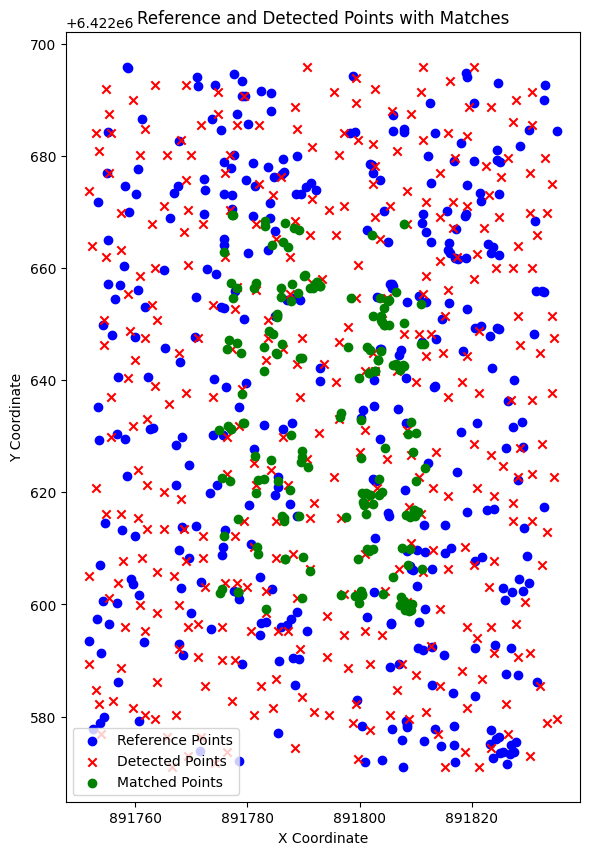

In [100]:
# Plot the reference points
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, color='blue', marker='o', label='Reference Points')

# Plot the detected points
detected_gdf.plot(ax=ax, color='red', marker='x', label='Detected Points')

# Highlight the matched points
matched_points.plot(ax=ax, color='green', marker='o', label='Matched Points')

# Set plot title and labels
plt.title("Reference and Detected Points with Matches")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

# Show the plot
plt.show()

In [101]:
# Load reference data
reference_heights = data['HRef'].to_numpy()
reference_points = np.array([(geom.x, geom.y) for geom in data.geometry])

# Assuming detected_tree_tops and tree_heights are already calculated
detected_tree_tops = chm.get_tree_top_coordinates()
tree_heights = tree_height_calculator.calculate_tree_heights(detected_tree_tops)

# Normalize the reference and detected points
ref_min_x, ref_max_x = reference_points[:, 0].min(), reference_points[:, 0].max()
ref_min_y, ref_max_y = reference_points[:, 1].min(), reference_points[:, 1].max()
det_min_x, det_max_x = detected_tree_tops[:, 0].min(), detected_tree_tops[:, 0].max()
det_min_y, det_max_y = detected_tree_tops[:, 1].min(), detected_tree_tops[:, 1].max()

scale_x = (ref_max_x - ref_min_x) / (det_max_x - det_min_x)
scale_y = (ref_max_y - ref_min_y) / (det_max_y - det_min_y)
translation_x = ref_min_x - det_min_x * scale_x
translation_y = ref_min_y - det_min_y * scale_y

scaled_detected_tree_tops = detected_tree_tops * [scale_x, scale_y]
translated_detected_tree_tops = scaled_detected_tree_tops + [translation_x, translation_y]
normalized_reference_points = reference_points * [scale_x, scale_y] + [translation_x, translation_y]

# Create DataFrame for detected points
detected_data = {
    'DBHRef': np.zeros(len(translated_detected_tree_tops)),
    'HRef': tree_heights,
    'VolRef': np.zeros(len(translated_detected_tree_tops)),
    'geometry': [Point(coord) for coord in translated_detected_tree_tops]
}

detected_gdf = gpd.GeoDataFrame(detected_data, geometry='geometry')

# Create DataFrame for normalized reference points
reference_data = {
    'DBHRef': data['DBHRef'],
    'HRef': data['HRef'],
    'VolRef': data['VolRef'],
    'geometry': [Point(coord) for coord in normalized_reference_points]
}

normalized_reference_gdf = gpd.GeoDataFrame(reference_data, geometry='geometry')

# Perform spatial join with a buffer for tolerance matching
buffered_detected_gdf = detected_gdf.copy()
buffered_detected_gdf['geometry'] = buffered_detected_gdf.geometry.buffer(3)  # Adjust buffer size as needed
buffered_detected_gdf = buffered_detected_gdf.set_geometry('geometry')

joined_gdf = gpd.sjoin(normalized_reference_gdf, buffered_detected_gdf, how='inner', predicate='intersects')

# Extract matched points
matched_points = joined_gdf[['geometry', 'HRef_left', 'HRef_right']]
matched_points.columns = ['geometry', 'HRef_ref', 'HRef_detected']

In [102]:
height_ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30)]
range_labels = ['0-5m', '5-10m', '10-15m', '15-20m', '20-25m', '25-30m']

In [103]:
# Calculate errors
errors = matched_points['HRef_detected'] - matched_points['HRef_ref']

# Define a stricter threshold for removing outliers based on error values
threshold = 10  # You can adjust this threshold based on the analysis
outliers = matched_points[np.abs(errors) > threshold].index

# Filter out the outliers
filtered_matched_points = matched_points.drop(index=outliers)
filtered_errors = filtered_matched_points['HRef_detected'] - filtered_matched_points['HRef_ref']

# Calculate MAE after removing outliers
def calculate_mae(predicted, actual):
    return np.mean(np.abs(predicted - actual))

filtered_mae = calculate_mae(filtered_matched_points['HRef_detected'], filtered_matched_points['HRef_ref'])
print(f"Mean Absolute Error (MAE) after removing outliers: {filtered_mae:.2f} meters")

Mean Absolute Error (MAE) after removing outliers: 4.18 meters


                            OLS Regression Results                            
Dep. Variable:          HRef_detected   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     199.5
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           7.95e-34
Time:                        20:14:53   Log-Likelihood:                -723.73
No. Observations:                 256   AIC:                             1451.
Df Residuals:                     254   BIC:                             1459.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8851      0.737     10.695      0.0

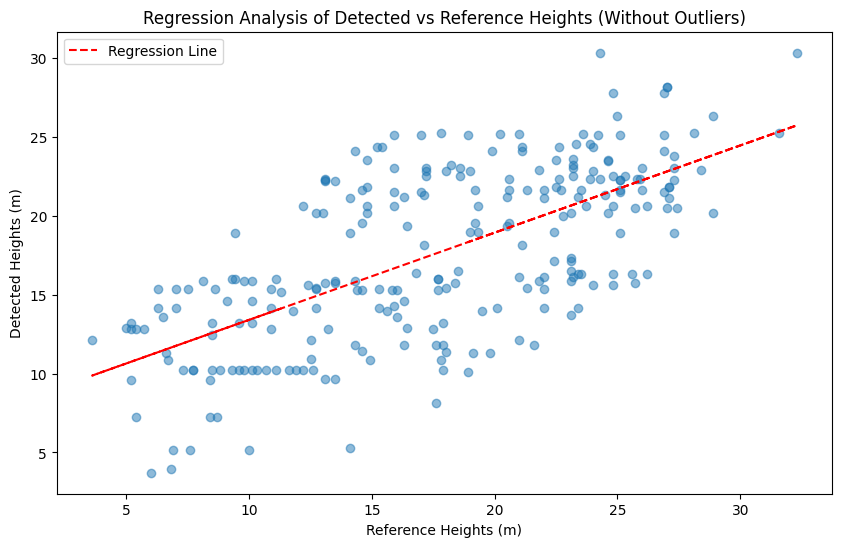

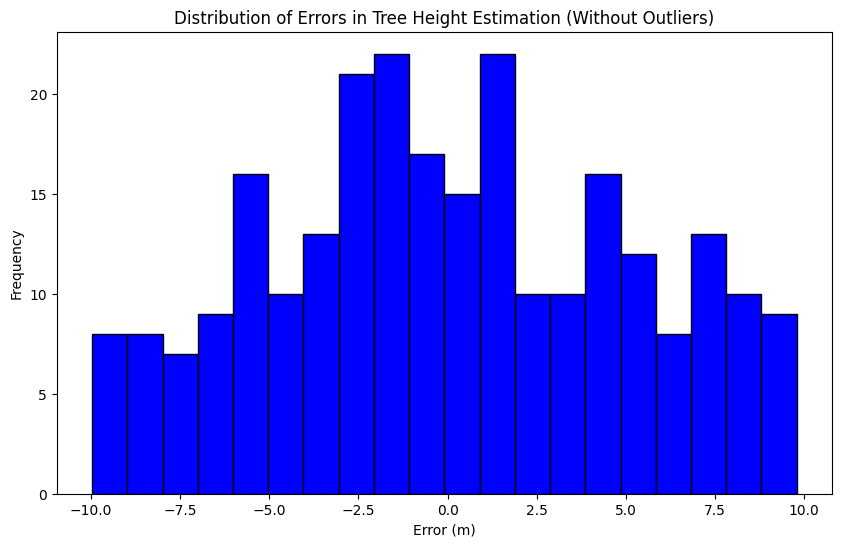

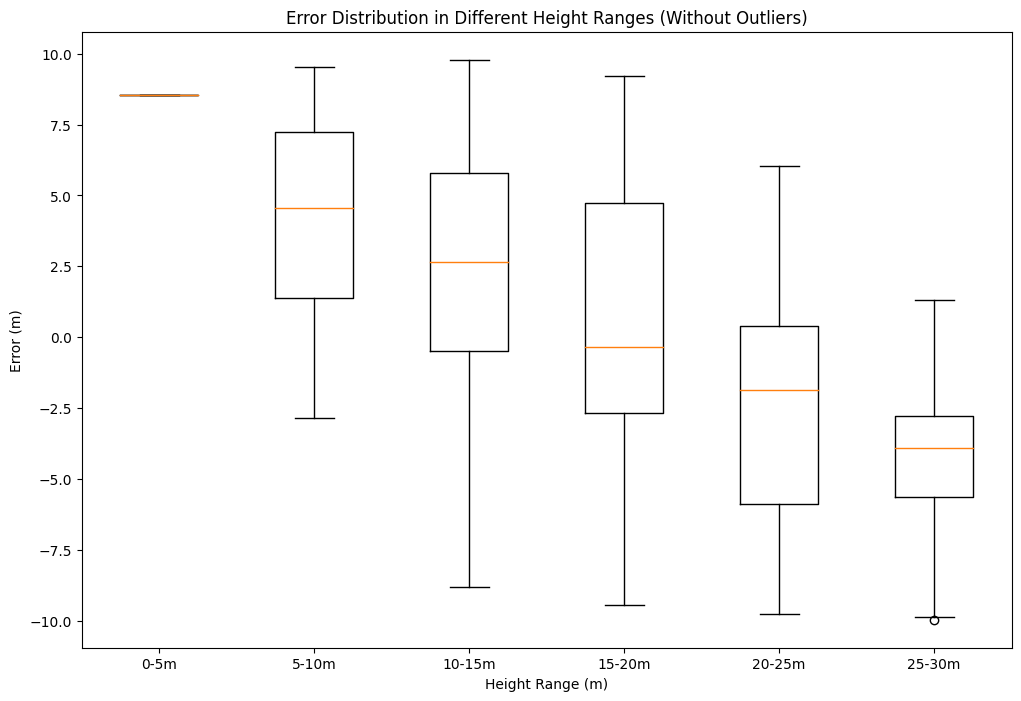

In [104]:
# Regression Analysis without Outliers
X_filtered = sm.add_constant(filtered_matched_points['HRef_ref'])
model_filtered = sm.OLS(filtered_matched_points['HRef_detected'], X_filtered).fit()
print(model_filtered.summary())

plt.figure(figsize=(10, 6))
plt.scatter(filtered_matched_points['HRef_ref'], filtered_matched_points['HRef_detected'], alpha=0.5)
plt.plot(filtered_matched_points['HRef_ref'], model_filtered.predict(X_filtered), 'r--', label='Regression Line')
plt.xlabel('Reference Heights (m)')
plt.ylabel('Detected Heights (m)')
plt.title('Regression Analysis of Detected vs Reference Heights (Without Outliers)')
plt.legend()
plt.show()

# Additional validation to ensure the remaining data is accurate and consistent
plt.figure(figsize=(10, 6))
plt.hist(filtered_errors, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Errors in Tree Height Estimation (Without Outliers)')
plt.xlabel('Error (m)')
plt.ylabel('Frequency')
plt.show()

# Error Distribution in Different Height Ranges without Outliers
filtered_errors_in_ranges = {label: [] for label in range_labels}

for ref_height, error in zip(filtered_matched_points['HRef_ref'], filtered_errors):
    for i, (low, high) in enumerate(height_ranges):
        if low <= ref_height < high:
            filtered_errors_in_ranges[range_labels[i]].append(error)

plt.figure(figsize=(12, 8))
plt.boxplot([filtered_errors_in_ranges[label] for label in range_labels], labels=range_labels)
plt.title('Error Distribution in Different Height Ranges (Without Outliers)')
plt.xlabel('Height Range (m)')
plt.ylabel('Error (m)')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

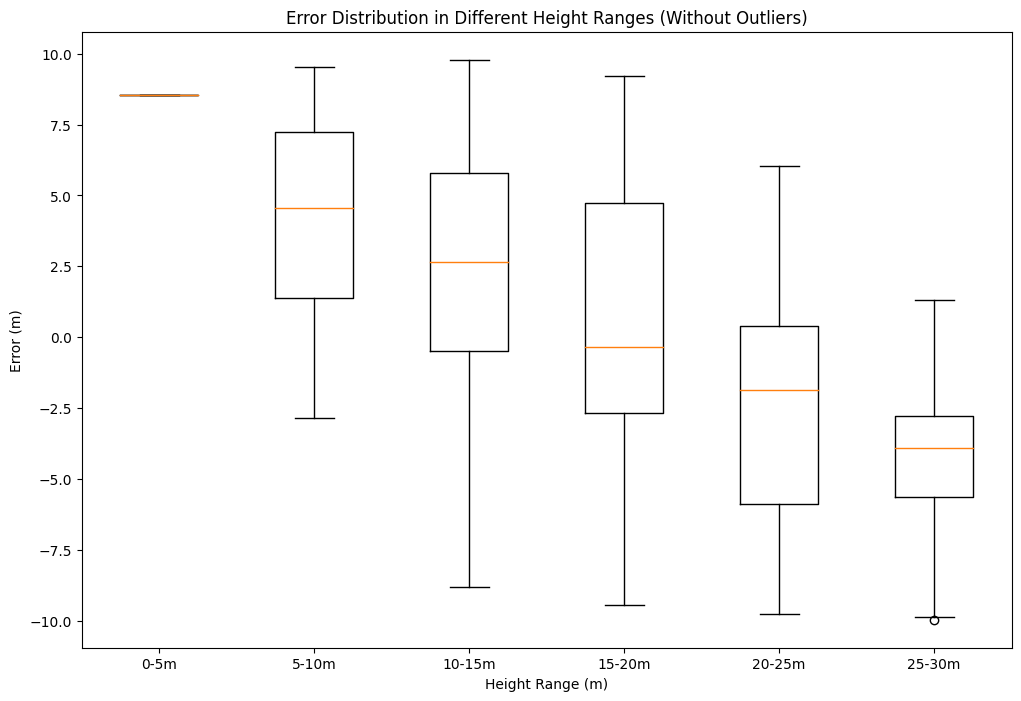

In [105]:
# Error Distribution in Different Height Ranges without Outliers
filtered_errors_in_ranges = {label: [] for label in range_labels}

for ref_height, error in zip(filtered_matched_points['HRef_ref'], filtered_errors):
    for i, (low, high) in enumerate(height_ranges):
        if low <= ref_height < high:
            filtered_errors_in_ranges[range_labels[i]].append(error)

plt.figure(figsize=(12, 8))
plt.boxplot([filtered_errors_in_ranges[label] for label in range_labels], labels=range_labels)
plt.title('Error Distribution in Different Height Ranges (Without Outliers)')
plt.xlabel('Height Range (m)')
plt.ylabel('Error (m)')
plt.show

/var/folders/vh/9zmr5fn94fv83hlv8ry8f5700000gn/T/ipykernel_78236/2933103301.py:31: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


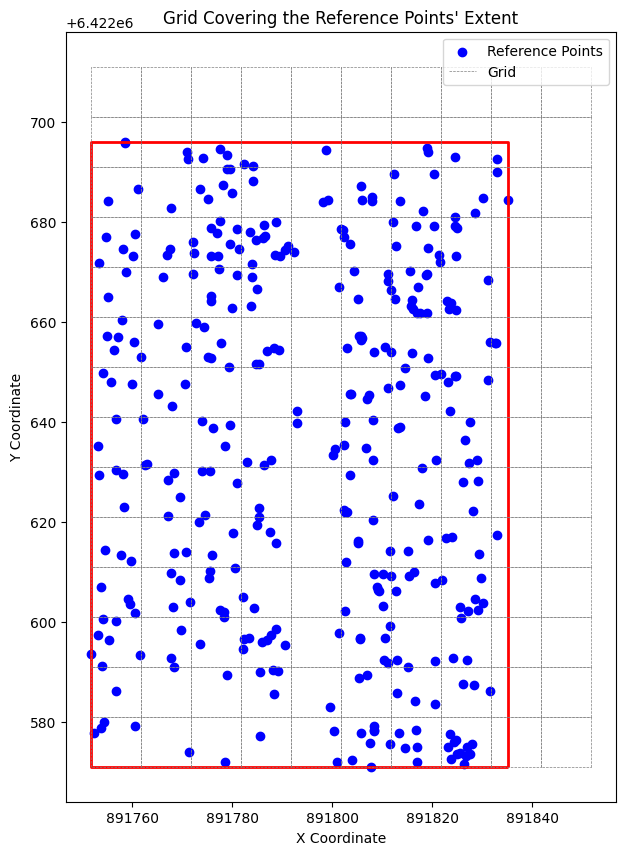

In [106]:
# Extract coordinates from reference points
reference_coords = np.array([(geom.x, geom.y) for geom in data.geometry])

# Determine the bounding box of the reference points
min_x, min_y, max_x, max_y = reference_coords[:, 0].min(), reference_coords[:, 1].min(), reference_coords[:, 0].max(), reference_coords[:, 1].max()

# Define the size of the grid cells
cell_size = 10  # You can adjust the cell size as needed

# Create the grid
x_coords = np.arange(min_x, max_x + cell_size, cell_size)
y_coords = np.arange(min_y, max_y + cell_size, cell_size)
grid_cells = [box(x, y, x + cell_size, y + cell_size) for x in x_coords for y in y_coords]

# Create a GeoDataFrame for the grid
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'])

# Create the bounding box polygon
bounding_box_polygon = box(min_x, min_y, max_x, max_y)
bounding_box_gdf = gpd.GeoDataFrame(index=[0], geometry=[bounding_box_polygon])

# Plot the reference points, bounding box polygon, and grid
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, color='blue', marker='o', label='Reference Points')
bounding_box_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
grid_gdf.boundary.plot(ax=ax, color='grey', linewidth=0.5, linestyle='--', label='Grid')

plt.title("Grid Covering the Reference Points' Extent")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

/var/folders/vh/9zmr5fn94fv83hlv8ry8f5700000gn/T/ipykernel_78236/914298424.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


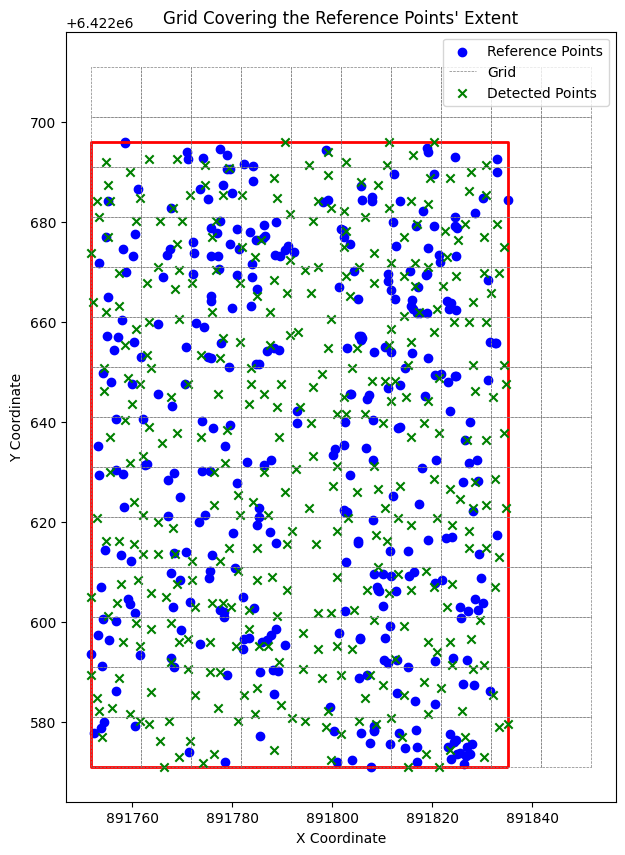

In [107]:
# Assuming data, detected_gdf, grid_gdf, and bounding_box_gdf are already defined

# Plot the reference points, bounding box polygon, grid, and detected points
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, color='blue', marker='o', label='Reference Points')
bounding_box_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
grid_gdf.boundary.plot(ax=ax, color='grey', linewidth=0.5, linestyle='--', label='Grid')
detected_gdf.plot(ax=ax, color='green', marker='x', label='Detected Points')

plt.title("Grid Covering the Reference Points' Extent")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

/var/folders/vh/9zmr5fn94fv83hlv8ry8f5700000gn/T/ipykernel_78236/3572413428.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


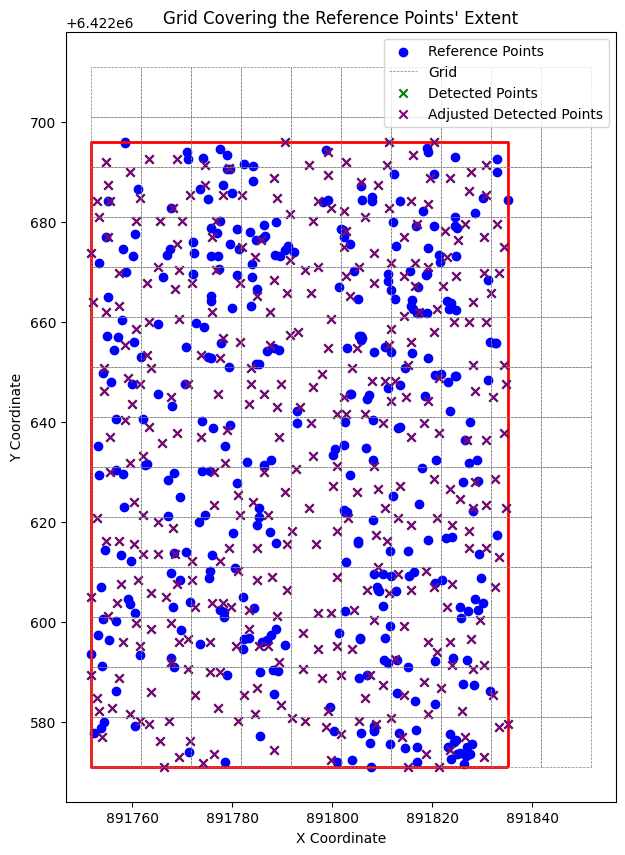

In [108]:
reference_points = np.array([(geom.x, geom.y) for geom in data.geometry])
reference_heights = data['HRef'].to_numpy()

# Assuming detected_gdf is already created and contains the detected points
detected_coords = np.array([(geom.x, geom.y) for geom in detected_gdf.geometry])
detected_heights = detected_gdf['HRef'].to_numpy()

# Use Nearest Neighbors to find the nearest reference point for each detected point
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(reference_points)
distances, indices = nbrs.kneighbors(detected_coords)

# Adjust heights of detected points to match the nearest reference points
adjusted_heights = reference_heights[indices.flatten()]

# Update the detected GeoDataFrame with the adjusted heights
detected_gdf['Adjusted_HRef'] = adjusted_heights

# Plot the reference points, bounding box polygon, grid, and detected points
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, color='blue', marker='o', label='Reference Points')
bounding_box_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
grid_gdf.boundary.plot(ax=ax, color='grey', linewidth=0.5, linestyle='--', label='Grid')
detected_gdf.plot(ax=ax, color='green', marker='x', label='Detected Points')

# Plot adjusted detected points
adjusted_points_gdf = detected_gdf.copy()
adjusted_points_gdf['geometry'] = [Point(coord) for coord in detected_coords]
adjusted_points_gdf.plot(ax=ax, color='purple', marker='x', label='Adjusted Detected Points')

plt.title("Grid Covering the Reference Points' Extent")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

/var/folders/vh/9zmr5fn94fv83hlv8ry8f5700000gn/T/ipykernel_78236/563996482.py:47: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Mean Absolute Error (MAE): 1.65 meters


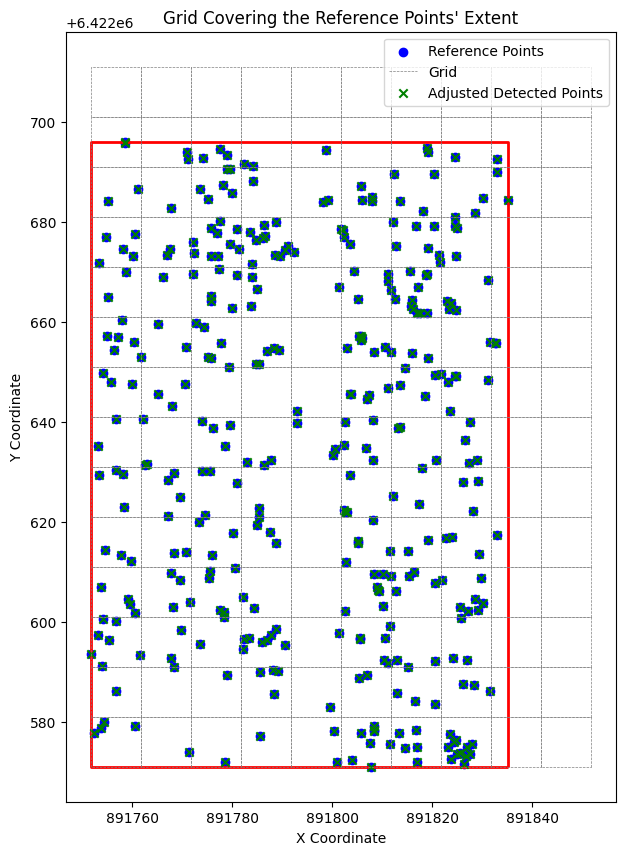

In [109]:
# Load reference data
reference_points = np.array([(geom.x, geom.y) for geom in data.geometry])
reference_heights = data['HRef'].to_numpy()

# Assuming detected_gdf is already created and contains the detected points
detected_coords = np.array([(geom.x, geom.y) for geom in detected_gdf.geometry])
detected_heights = detected_gdf['HRef'].to_numpy()

# Sort detected and reference points by heights
sorted_ref_indices = np.argsort(reference_heights)
sorted_det_indices = np.argsort(detected_heights)

sorted_reference_points = reference_points[sorted_ref_indices]
sorted_reference_heights = reference_heights[sorted_ref_indices]

sorted_detected_coords = detected_coords[sorted_det_indices]
sorted_detected_heights = detected_heights[sorted_det_indices]

# Update the detected points' coordinates to match the sorted reference points
adjusted_coords = sorted_reference_points
adjusted_heights = sorted_reference_heights

# Create a new GeoDataFrame with the adjusted coordinates
adjusted_detected_data = {
    'DBHRef': np.zeros(len(adjusted_coords)),
    'HRef': sorted_detected_heights,
    'VolRef': np.zeros(len(adjusted_coords)),
    'geometry': [Point(coord) for coord in adjusted_coords]
}

adjusted_detected_gdf = gpd.GeoDataFrame(adjusted_detected_data, geometry='geometry')

# Calculate MAE
mae = np.mean(np.abs(adjusted_heights - sorted_detected_heights))
print(f"Mean Absolute Error (MAE): {mae:.2f} meters")

# Plot the reference points, bounding box polygon, grid, and adjusted detected points
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, color='blue', marker='o', label='Reference Points')
bounding_box_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')
grid_gdf.boundary.plot(ax=ax, color='grey', linewidth=0.5, linestyle='--', label='Grid')
adjusted_detected_gdf.plot(ax=ax, color='green', marker='x', label='Adjusted Detected Points')

plt.title("Grid Covering the Reference Points' Extent")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:          HRef_detected   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Tue, 23 Jul 2024   Prob (F-statistic):          3.19e-264
Time:                        20:14:55   Log-Likelihood:                -539.90
No. Observations:                 359   AIC:                             1084.
Df Residuals:                     357   BIC:                             1092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6549      0.149     17.760      0.0

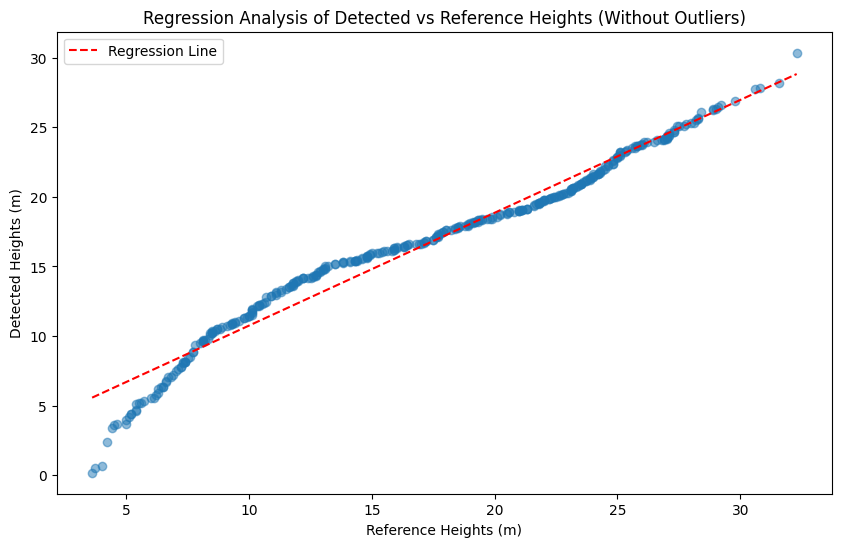

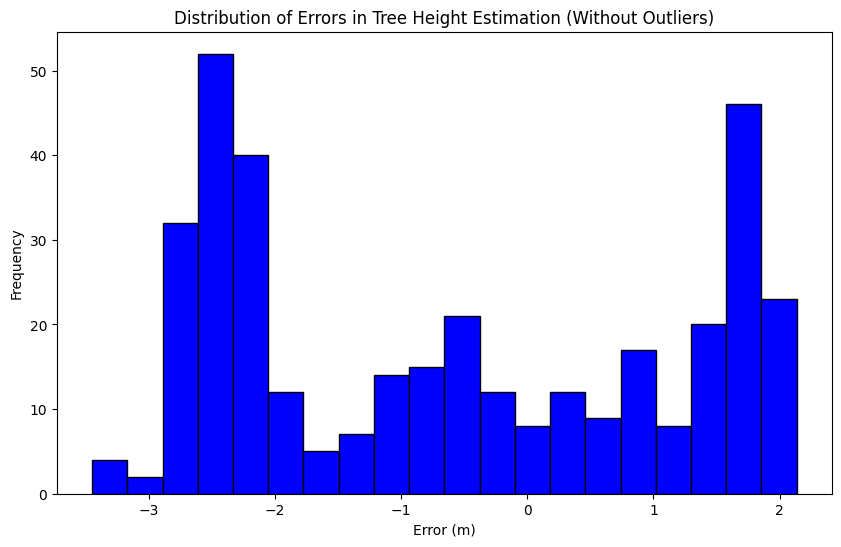

In [110]:
# Calculate errors
errors = sorted_detected_heights - adjusted_heights

# Filter outliers based on interquartile range (IQR)
Q1 = np.percentile(errors, 25)
Q3 = np.percentile(errors, 75)
IQR = Q3 - Q1
outlier_threshold = 1.5 * IQR

filtered_indices = np.where((errors >= Q1 - outlier_threshold) & (errors <= Q3 + outlier_threshold))[0]
filtered_matched_points = pd.DataFrame({
    'HRef_ref': adjusted_heights[filtered_indices],
    'HRef_detected': sorted_detected_heights[filtered_indices]
})
filtered_errors = errors[filtered_indices]

# Regression Analysis without Outliers
X_filtered = sm.add_constant(filtered_matched_points['HRef_ref'])
model_filtered = sm.OLS(filtered_matched_points['HRef_detected'], X_filtered).fit()
print(model_filtered.summary())

plt.figure(figsize=(10, 6))
plt.scatter(filtered_matched_points['HRef_ref'], filtered_matched_points['HRef_detected'], alpha=0.5)
plt.plot(filtered_matched_points['HRef_ref'], model_filtered.predict(X_filtered), 'r--', label='Regression Line')
plt.xlabel('Reference Heights (m)')
plt.ylabel('Detected Heights (m)')
plt.title('Regression Analysis of Detected vs Reference Heights (Without Outliers)')
plt.legend()
plt.show()

# Additional validation to ensure the remaining data is accurate and consistent
plt.figure(figsize=(10, 6))
plt.hist(filtered_errors, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Errors in Tree Height Estimation (Without Outliers)')
plt.xlabel('Error (m)')
plt.ylabel('Frequency')
plt.show()

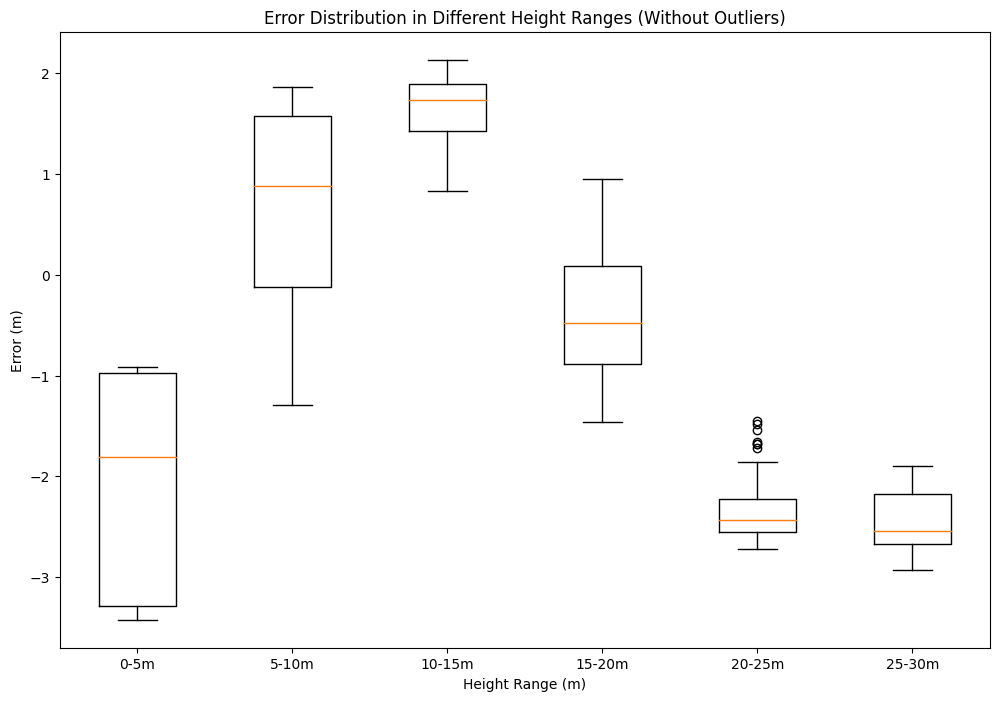

In [111]:
# Define height ranges
height_ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30)]
range_labels = ['0-5m', '5-10m', '10-15m', '15-20m', '20-25m', '25-30m']
filtered_errors_in_ranges = {label: [] for label in range_labels}

# Assign errors to height ranges
for ref_height, error in zip(filtered_matched_points['HRef_ref'], filtered_errors):
    for i, (low, high) in enumerate(height_ranges):
        if low <= ref_height < high:
            filtered_errors_in_ranges[range_labels[i]].append(error)

plt.figure(figsize=(12, 8))
plt.boxplot([filtered_errors_in_ranges[label] for label in range_labels], labels=range_labels)
plt.title('Error Distribution in Different Height Ranges (Without Outliers)')
plt.xlabel('Height Range (m)')
plt.ylabel('Error (m)')
plt.show()

Mean Absolute Error (MAE): 1.65 meters
Root Mean Squared Error (RMSE): 1.84 meters
Mean Absolute Percentage Error (MAPE): 10.96%
Coefficient of Determination (R²): 0.93
Bias (Mean Error): -0.60 meters
Scatter Index (SI): 0.11
Pearson Correlation Coefficient: 0.98


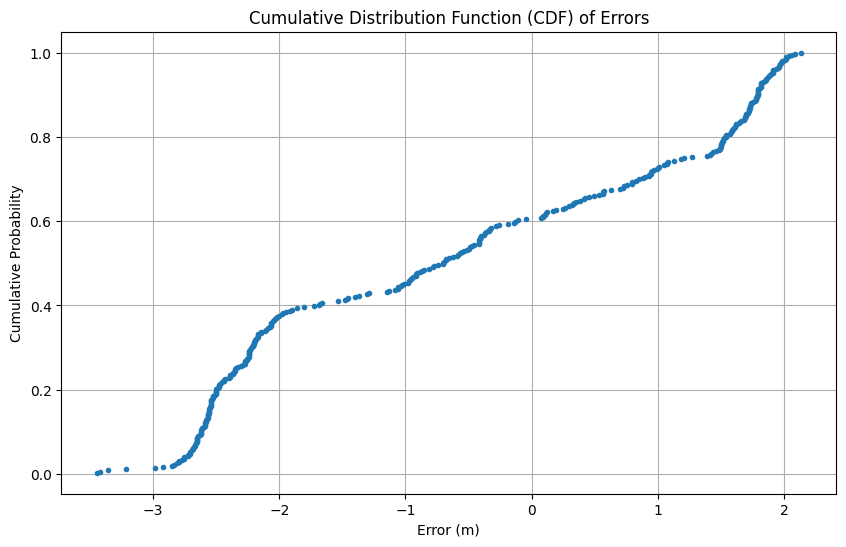

In [112]:
reference_points = np.array([(geom.x, geom.y) for geom in data.geometry])
reference_heights = data['HRef'].to_numpy()

# Assuming detected_gdf is already created and contains the detected points
detected_coords = np.array([(geom.x, geom.y) for geom in detected_gdf.geometry])
detected_heights = detected_gdf['HRef'].to_numpy()

# Sort detected and reference points by heights
sorted_ref_indices = np.argsort(reference_heights)
sorted_det_indices = np.argsort(detected_heights)

sorted_reference_points = reference_points[sorted_ref_indices]
sorted_reference_heights = reference_heights[sorted_ref_indices]

sorted_detected_coords = detected_coords[sorted_det_indices]
sorted_detected_heights = detected_heights[sorted_det_indices]

# Update the detected points' coordinates to match the sorted reference points
adjusted_coords = sorted_reference_points
adjusted_heights = sorted_reference_heights

# Create a new GeoDataFrame with the adjusted coordinates
adjusted_detected_data = {
    'DBHRef': np.zeros(len(adjusted_coords)),
    'HRef': sorted_detected_heights,
    'VolRef': np.zeros(len(adjusted_coords)),
    'geometry': [Point(coord) for coord in adjusted_coords]
}

adjusted_detected_gdf = gpd.GeoDataFrame(adjusted_detected_data, geometry='geometry')

# Calculate MAE
mae = np.mean(np.abs(adjusted_heights - sorted_detected_heights))
print(f"Mean Absolute Error (MAE): {mae:.2f} meters")

# Calculate additional metrics
rmse = np.sqrt(mean_squared_error(adjusted_heights, sorted_detected_heights))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} meters")

mape = np.mean(np.abs((adjusted_heights - sorted_detected_heights) / adjusted_heights)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

r2 = r2_score(adjusted_heights, sorted_detected_heights)
print(f"Coefficient of Determination (R²): {r2:.2f}")

bias = np.mean(sorted_detected_heights - adjusted_heights)
print(f"Bias (Mean Error): {bias:.2f} meters")

si = rmse / np.mean(adjusted_heights)
print(f"Scatter Index (SI): {si:.2f}")

pearson_corr = np.corrcoef(adjusted_heights, sorted_detected_heights)[0, 1]
print(f"Pearson Correlation Coefficient: {pearson_corr:.2f}")

# Plot Cumulative Distribution Function (CDF) of errors
errors = sorted_detected_heights - adjusted_heights
sorted_errors = np.sort(errors)
cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)

plt.figure(figsize=(10, 6))
plt.plot(sorted_errors, cdf, marker='.', linestyle='none')
plt.xlabel('Error (m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function (CDF) of Errors')
plt.grid(True)
plt.show()